Im Notebook exploration.ipynb wird das CV Model trainiert.

Es speichert das trainierte Modell als 'resnet34-stage-final' und 'export_resnet34.pkl'.

Using images path: /workspaces/PS9-Boston-Dynamic-Mobile-CV-Testing-Systems/data/images
Verfügbare Device(s): cpu
train_csv: parsed 35 entries, missing 0
valid_csv: parsed 14 entries, missing 0
=== DATASET / DATALOADER DIAGNOSTICS ===
dls.vocab: ['analog', 'digital_ac', 'digital_temp']
n_train: 35 n_valid: 14
train label counts (sample): Counter({0: 17, 1: 17, 2: 1})
valid label counts (sample): Counter({1: 8, 0: 6})
Loaded train batch: xb.shape= torch.Size([16, 3, 460, 460])  yb.shape= torch.Size([16])
xb min/max/mean anynan: 0.0 1.0 0.5379271507263184 False
yb unique: TensorCategory([0, 1])


/workspaces/PS9-Boston-Dynamic-Mobile-CV-Testing-Systems/.venv/lib/python3.11/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


preds shape / anynan / anyinf: torch.Size([16, 3]) False False
batch loss (forward test): 2.2846808433532715
Starte lr_find...


LR-Find suggestion: SuggestedLRs(valley=0.0020892962347716093)
Starte erstes Training: 5 Epochen mit lr= SuggestedLRs(valley=0.0020892962347716093)


epoch,train_loss,valid_loss,accuracy,time
0,1.260723,2.189270,0.500000,00:30


epoch,train_loss,valid_loss,accuracy,time
0,0.283071,1.201146,0.571429,00:42
1,0.206315,0.355222,0.857143,00:39
2,0.194972,0.166934,0.928571,00:38
3,0.147834,0.053608,1.000000,00:38
4,0.116065,0.026384,1.000000,00:38


Feinabstimmung: unfreeze und weiteres Training mit niedrigerer LR


epoch,train_loss,valid_loss,accuracy,time
0,0.018009,0.014189,1.000000,00:38
1,0.010499,0.006786,1.000000,00:38
2,0.012913,0.004039,1.000000,00:39


Training abgeschlossen. Modell gespeichert als 'resnet34-stage-final' und 'export_resnet34.pkl'.


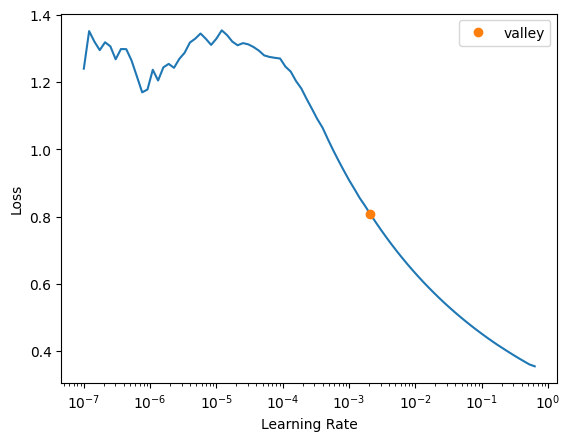

In [ ]:
# train_fastai.py
# Training eines Bildklassifikations-Modells mit fastai
# Train-Bilder: data/images/train, Validierungs-Bilder: data/images/val

from pathlib import Path
import sys
import subprocess

# fastai installieren falls nicht vorhanden
try:
    from fastai.vision.all import *
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "fastai"])
    from fastai.vision.all import *

import torch
import csv

def main():
    path = Path("/workspaces/PS9-Boston-Dynamic-Mobile-CV-Testing-Systems") / "data" / "images"
    print("Using images path:", path)
    train_folder = path/"train"
    valid_folder = path/"val"

    if not train_folder.exists() or not valid_folder.exists():
        raise FileNotFoundError(f"Benötigte Ordner nicht gefunden: {train_folder} oder {valid_folder}")
    
    # Device Auswahl: GPU wenn verfügbar
    try:
        dev = defaults.device
    except Exception:
        dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Verfügbare Device(s):", dev)
    # DataLoaders: Ordnerstruktur erwartet pro Klasse einen Unterordner
    
    train_csv = path/'train'/'train_labels.csv'
    valid_csv = path/'val'/'val_labels.csv'

    def read_labels(csv_path, subfolder):
        items = []
        labels = {}
        if not csv_path.exists():
            return items, labels
        with csv_path.open('r', newline='') as f:
            reader = csv.reader(f, delimiter=';')
            for row in reader:
                if not row:
                    continue
                name = row[0].strip()
                label = row[1].strip() if len(row) > 1 else ''
                if not name:
                    continue
                p = Path(name)
                # normalize: relative names -> under images/<subfolder>
                if not p.is_absolute():
                    if p.parent == Path('.'):
                        p = path / subfolder / p.name
                    else:
                        p = path / p
                p = p.resolve()
                items.append(p)
                labels[p] = label
        return items, labels

    train_items, train_labels = read_labels(train_csv, 'train')
    valid_items, valid_labels = read_labels(valid_csv, 'val')

    # Diagnose / Existenzprüfung
    def _check_items(items, kind):
        missing = [p for p in items if not p.exists()]
        print(f"{kind}: parsed {len(items)} entries, missing {len(missing)}")
        if missing:
            print("Fehlende Beispiel-Dateien:", missing[:5])
        return missing
    missing_train = _check_items(train_items, "train_csv")
    missing_valid = _check_items(valid_items, "valid_csv")
    if missing_train or missing_valid:
        raise FileNotFoundError("Einige in CSV gelistete Bilddateien wurden nicht gefunden (siehe Ausgabe).")

    # Wenn CSVs erfolgreich eingelesen wurden: DataBlock mit diesen Items verwenden
    if train_items and valid_items:
        all_items = train_items + valid_items
        labels_map = {**train_labels, **valid_labels}
        valid_set = set(valid_items)

        dblock = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_items=lambda _=None: all_items,
            get_y=lambda o: labels_map[o],
            splitter=FuncSplitter(lambda o: o in valid_set),
            item_tfms=Resize(460),
            batch_tfms=aug_transforms(size=224)
        )
        dls = dblock.dataloaders(path, bs=64)
    else:
        # fallback wird weiter unten behandelt
        pass

    if train_items and valid_items:        
        all_items = train_items + valid_items
        labels_map = {**train_labels, **valid_labels}
        # normalize keys to str for robust lookup during transforms/collation
        labels_map_str = {str(k): v for k, v in labels_map.items()}
        valid_set = set(valid_items)

        dblock = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_items=lambda _=None: all_items,
            get_y=lambda o: labels_map_str.get(str(o)),
            splitter=FuncSplitter(lambda o: o in valid_set),
            item_tfms=Resize(460),
            batch_tfms=[]   # disable heavy batch transforms for now (debug)
        )
        dls = dblock.dataloaders(path, bs=16, num_workers=0)

    else:
        # Fallback: vorhandene Ordnerstruktur verwenden
        # Robustes get_image_files: versuche fastai-Import, sonst Fallback via Path.rglob
        try:
            from fastai.vision.all import get_image_files
        except Exception:
            def get_image_files(p):
                exts = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tif', '.tiff'}
                return [f for f in Path(p).rglob('*') if f.suffix.lower() in exts]

        # Diagnose: welche Bilddateien werden gefunden?
        train_imgs = list(get_image_files(train_folder))
        valid_imgs = list(get_image_files(valid_folder))
        print(f"Found {len(train_imgs)} train images, {len(valid_imgs)} valid images")
        if len(train_imgs) == 0 or len(valid_imgs) == 0:
            print("WARN: train/val folders contain no images (check extensions / nested structure).")

        # Robustes DataBlock: erwartet Struktur repo/data/images/{train,val}/{class}/*.jpg
        # Labels werden aus dem parent-Ordner (Klassenname) genommen; Split nach Grandparent (train/val).
        dblock = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_items=get_image_files,
            get_y=lambda o: o.parent.name,                 # Klasse ist Ordner direkt über dem Bild
            splitter=GrandparentSplitter(train_name='train', valid_name='val'),
            item_tfms=Resize(460),
            batch_tfms=aug_transforms(size=224)
        )
        dls = dblock.dataloaders(path, bs=64)

    # Enhanced diagnostics: verify dls, batch, forward and loss (inserted here)
    from collections import Counter
    print("=== DATASET / DATALOADER DIAGNOSTICS ===")
    if 'dls' not in locals() and 'dls' not in globals():
        print("ERROR: 'dls' nicht gefunden. Stelle sicher, dass dls vor dieser Stelle erstellt wird.")
    else:
        print("dls.vocab:", getattr(dls, "vocab", None))
        print("n_train:", len(dls.train_ds), "n_valid:", len(dls.valid_ds))
        def sample_label_counts(ds, n=500):
            cnt = Counter()
            for i in range(min(len(ds), n)):
                _, y = ds[i]
                if hasattr(y, "item"):
                    cnt[int(y.item())] += 1
                else:
                    cnt[str(y)] += 1
            return cnt
        print("train label counts (sample):", sample_label_counts(dls.train_ds))
        print("valid label counts (sample):", sample_label_counts(dls.valid_ds))

        # try to load one batch
        import traceback
        xb = yb = None
        try:
            xb, yb = next(iter(dls.train))
            print("Loaded train batch: xb.shape=", getattr(xb, "shape", None), " yb.shape=", getattr(yb, "shape", None))
            print("xb min/max/mean anynan:", float(xb.min()), float(xb.max()), float(xb.mean()), bool(torch.isnan(xb).any()))
            print("yb unique:", torch.unique(yb))
        except Exception as e:
            print("Could not fetch train batch. Exception type/message:", type(e), e)
            print("Traceback:\n", traceback.format_exc())

        # lightweight forward + loss test using a temporary small model
        try:
            if xb is None:
                print("Skipping forward/loss test because no train batch available.")
            else:
                tmp_learn = cnn_learner(dls, resnet18, metrics=[])
                model = tmp_learn.model.to(xb.device)
                with torch.no_grad():
                    preds = model(xb)
                print("preds shape / anynan / anyinf:", preds.shape, bool(torch.isnan(preds).any()), bool(torch.isinf(preds).any()))
                loss = tmp_learn.loss_func(preds, yb.long())
                print("batch loss (forward test):", float(loss))
        except Exception as e:
            print("Forward/loss test failed. Exception type/message:", type(e), e)
            print("Traceback:\n", traceback.format_exc())

    # Model: ResNet34 als Startpunkt
    learn = cnn_learner(dls, resnet34, metrics=[accuracy])

    # Optional: learning rate Suche (auskommentieren, wenn Probleme)
    try:
        print("Starte lr_find...")
        lr_suggestion = learn.lr_find(suggest_funcs=(valley,))
        print("LR-Find suggestion:", lr_suggestion)
    except Exception:
        # Falls lr_find Probleme macht (Headless/Plot), verwenden wir Default
        print("lr_find fehlgeschlagen oder nicht möglich; Verwende Standard lr 3e-3")
        lr_suggestion = 3e-3

    # Erste Trainingsphase
    print("Starte erstes Training: 5 Epochen mit lr=", lr_suggestion)
    learn.fine_tune(5, base_lr=3e-3)

    # Feinabstimmung: unfreeze und niedrigeres LR für alle Schichten
    print("Feinabstimmung: unfreeze und weiteres Training mit niedrigerer LR")
    learn.unfreeze()
    learn.fit_one_cycle(3, lr_max=slice(1e-6, 1e-4))

    # Modell speichern / exportieren für Inferenz
    learn.save("resnet34-stage-final")
    learn.export("export_resnet34.pkl")  #gespeichert in src/common/cvision/notebooks/export_resnet34.pkl und kann mit load_learner wieder geladen werden

    print("Training abgeschlossen. Modell gespeichert als 'resnet34-stage-final' und 'export_resnet34.pkl'.")

    # return dataloaders and helper variables so notebook scope can inspect them
    return dls, locals().get('all_items'), locals().get('labels_map'), locals().get('valid_set')

if __name__ == "__main__":
    dls, all_items, labels_map, valid_set = main()

Batch Diagnose Test

Bildüberprüfung

In [2]:
# quick check: show a few sample item paths and try opening them
import dis
from PIL import Image
from pathlib import Path
# Determine sample paths robustly: prefer dls if available, otherwise fallback to filesystem search
paths = None
try:
    if 'dls' in globals() or 'dls' in locals():
        sample_items = getattr(dls.train_ds, "items", None)
        if sample_items:
            paths = list(sample_items)[:20]
            print("Sample train item paths (from dls):", paths[:10])
except Exception:
    paths = None

if not paths:
    exts = globals().get("image_extensions", {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tif', '.tiff'})
    base = Path("data") / "images" / "train"
    if not base.exists():
        base = Path("data/images/train")
    if not base.exists():
        base = Path(".")
    paths = [p for p in base.rglob('*') if p.suffix.lower() in exts][:20]
    print("Sample train item paths (filesystem fallback):", paths[:10])
# verify sample image files from the computed `paths` list (fallback already built above)
ok = 0
bad = 0
bad_list = []

if not paths:
    print("No sample paths to check (paths is empty).")
else:
    import traceback
    for p in paths[:20]:
        try:
            img = Image.open(p)
            img.verify()                 # detect truncated/corrupt files
            img = Image.open(p)          # re-open to get size/mode
            print(p, "opened ok, size=", img.size, "mode=", img.mode)
            img.close()
            ok += 1
        except Exception as e:
            print("Could not open", p, ":", type(e).__name__, e)
            print(traceback.format_exc())
            bad += 1
            bad_list.append(p)

    print(f"Checked {ok+bad} files: {ok} OK, {bad} failed.")
    if bad_list:
        print("Failed files (up to 10):", bad_list[:10])


Sample train item paths (filesystem fallback): []
No sample paths to check (paths is empty).
